In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

# Settings

In [4]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4
IN_CHANNELS = 1
N_CLASSES = 1
EPOCH =200

### Model Settings

#### encoder

In [5]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [6]:
DECODER_ATT = None

#### head

In [7]:
ACT = "sigmoid"
AUX_PARAM = None

### Optimizer Settings

In [8]:
OPTIM_NAME = "sgd"
init_lr = 1e-3
momentum = 0.9

# Epochs

In [9]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR
from codes.activation import Activation
from codes.utils import hu_clip_tensor

In [10]:
def train_epoch(model, optimizer, dataloader, device):
  
    # change mode to train and move to current device
    model = model.train().to(device)

    ssim_l = 0
    mae_l = 0
    mask_l = 0
    for index, data in tqdm(enumerate(dataloader)):
        
        _, y, _, mask_y, *_ = data

        y = y.to(device)
        mask_y = mask_y.to(device)

        y_pr = model(y)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]

        # main loss
        _mae = MAELoss()(y_pr.float(), y.float())
        _ssim =SSIMLoss()(y_pr, y, data_range=1.0, size_average=True) # return (N,)
        
        # auxilary loss
        y_min = -500
        y_max = 500
        upper = ((-256) - (y_min))/(y_max-(y_min))
        lower = ((-257) - (y_min))/(y_max-(y_min))
        mask_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        _mask = nn.BCELoss()(mask_pr.float(), mask_y.float())
        
        _loss = _ssim + _mae + _mask
                        
        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        mask_l += _mask.item()
        ssim_l += _ssim.item()
        mae_l += _mae.item()

    return  mae_l/(index+1), ssim_l/(index+1), mask_l/(index+1)

In [11]:
@torch.no_grad()
def eval_epoch(model, dataloader, device):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    mask_ = []
    for index, data in tqdm(enumerate(dataloader)):

        _, y, _, mask_y, _, _, y_min, y_max = data


        y = y.to(device)
        mask_y = mask_y.to(device)

        y_pr = model(y)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]

        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]

        # auxilary loss
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        mask_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)
        dice = Fscore()(mask_pr, mask_y)
        
        mask_ += [dice.item()]
        
    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), sum(mask_)/len(mask_)

In [12]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)

    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        _, y, _, mask_y, _, _, y_min, y_max = data


        y = y.to(device)
        mask_y = mask_y.to(device)

        y_pr = model(y)
        y_pr = Activation(name=ACT)(y_pr) # zipped value to [0, 1]
        
        upper = ((-256) - (-500))/(500-(-500))
        lower = ((-257) - (-500))/(500-(-500))
        mask_pr = hu_clip_tensor(y_pr.double(), upper, lower, True)

        for b in range(x.shape[0]):
            
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_mask = mask_y[b, :, :, :].unsqueeze(0)
            tmp_mask_pr = mask_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _dice = Fscore()(tmp_mask_pr, tmp_mask)
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("mask dice score = {}".format(_dice.item()))
            

            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __mask = (tmp_mask.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __mask_pr = (tmp_mask_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                ct_y = __ct,
                ct_pred = __ct_pred,
                mask = __mask,
                mask_pr = __mask_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                os.mkdir(path_dir)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "mask.jpg"), __mask)
                cv2.imwrite(os.path.join(path_dir, "mask_pred.jpg"), __mask_pr)
                  
            iid += 1

# Read Data

In [13]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [14]:
train_case_path = 'data/train/*_*'
test_case_path = 'data/test/*_*'

In [15]:
trainset = Dataset(path=train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, intensity_aug=aug.validation_intensity_augmentation(), geometry_aug=aug.get_validation_augmentation())

In [16]:
len(trainset), len(testset)

(1344, 191)

In [17]:
x, y, mask_x, mask_y, *_ = trainset[20]

In [18]:
np.min(mask_y)

0.0

In [19]:
np.max(mask_y)

1.0

(<matplotlib.image.AxesImage at 0x7efb61b50b50>,)

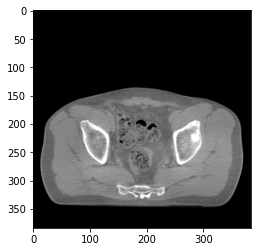

In [20]:
plt.imshow(x.squeeze(), 'gray'),

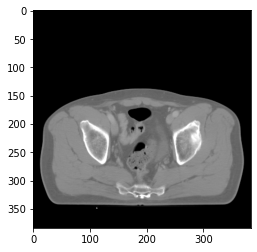

In [21]:
plt.imshow(y.squeeze(), 'gray')

In [22]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

## Model

In [23]:
class Model(nn.Module):
    def __init__(self, encoder, decoder, head):
        
        super(Model, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.head = head
        
        
    def forward(self, x):
        
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Running

In [24]:
import wandb

wandb.init(project="ct_rebuild", config={
    "data": {
        "in_channels": IN_CHANNELS,
        "out_channels": N_CLASSES,
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "optimizer": OPTIM_NAME,
        "init_lr": init_lr,
        "momentum": momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": ACT,
        "decoder_attention_type": DECODER_ATT
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [25]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [26]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

encoder = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)
encoder = encoder.encoder

decoder = UnetDecoder(
                            encoder_channels=[IN_CHANNELS, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=DECODER_ATT)

head = SegmentationHead(
                        in_channels=16,
                        out_channels=1,
                        activation=None)


model = Model(encoder, decoder, head)

del encoder, decoder, head

In [27]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
optimizer = Optimizer(model.parameters(), name=OPTIM_NAME, lr=init_lr)

In [28]:
wandb.watch(model)

min_mae = 99999

for epoch in range(EPOCH):
        
        loss_mae, loss_ssim, loss_mask = train_epoch(model, optimizer, trainloader, device)
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, score_mask_train = eval_epoch(model, trainloader, device)
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test = eval_epoch(model, testloader, device)

        wandb.log({
            "ssim loss": loss_ssim,
            "mae loss": loss_mae,
            "loss mask": loss_mask,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_mask_train,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_mask_test
        })
        
        
        if score_mae_test < min_mae:
            min_mae = score_mae_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict()
            }
            torch.save(checkpoint, os.path.join("{}.pth".format(wandb.run.name)))

336it [00:56,  5.97it/s]
336it [00:18, 18.62it/s]
48it [00:02, 18.02it/s]
336it [00:55,  6.01it/s]
336it [00:18, 18.57it/s]
48it [00:02, 17.61it/s]
336it [00:56,  5.94it/s]
336it [00:18, 18.61it/s]
48it [00:02, 17.80it/s]
336it [00:56,  5.96it/s]
336it [00:18, 18.60it/s]
48it [00:02, 17.61it/s]
336it [00:56,  5.95it/s]
336it [00:18, 18.49it/s]
48it [00:02, 17.80it/s]
336it [00:56,  5.90it/s]
336it [00:18, 18.57it/s]
48it [00:02, 17.60it/s]
336it [00:56,  5.93it/s]
336it [00:18, 18.65it/s]
48it [00:02, 17.58it/s]
336it [00:56,  5.93it/s]
336it [00:17, 18.77it/s]
48it [00:02, 17.40it/s]
336it [00:56,  5.90it/s]
336it [00:17, 18.83it/s]
48it [00:02, 17.60it/s]
336it [00:56,  5.92it/s]
336it [00:18, 18.61it/s]
48it [00:02, 17.50it/s]
336it [00:56,  5.94it/s]
336it [00:18, 18.41it/s]
48it [00:02, 17.54it/s]
336it [00:56,  5.91it/s]
336it [00:18, 18.30it/s]
48it [00:02, 17.45it/s]
336it [00:56,  5.91it/s]
336it [00:18, 18.56it/s]
48it [00:02, 17.55it/s]
336it [00:56,  5.90it/s]
336it [00:17,

In [29]:
run_name = wandb.run.name
# run_name = "apricot-puddle-56"

In [30]:
checkpoint = torch.load(os.path.join("{}.pth".format(run_name)))

In [31]:
encoder = smp.Unet(encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHT, in_channels=IN_CHANNELS, classes=N_CLASSES)
encoder = encoder.encoder

decoder = UnetDecoder(
                            encoder_channels=[IN_CHANNELS, 0, 0, 0, 0, 2048],
                            decoder_channels=[256, 128, 64, 32, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=DECODER_ATT)

head = SegmentationHead(
                        in_channels=16,
                        out_channels=1,
                        activation=None)


model = Model(encoder, decoder, head)

del encoder, decoder, head

In [32]:
try:
    os.mkdir(os.path.join("eval-autoencoder", run_name))
except FileExistsError:
    print("file exists")

0it [00:00, ?it/s]

ssim score = 0.3484977185726166
psnr score = 5.882847309112549
snr score = -4.054215431213379
mae error = 0.3354341685771942
mask dice score = 0.04717620584138061


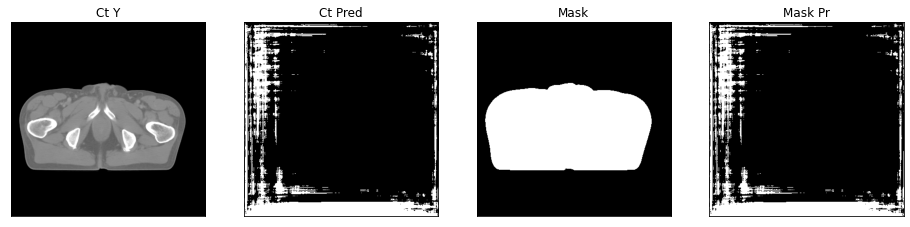

1it [00:00,  1.78it/s]

ssim score = 0.3375982344150543
psnr score = 5.682879447937012
snr score = -3.914196491241455
mae error = 0.34559598565101624
mask dice score = 0.042209019715038876


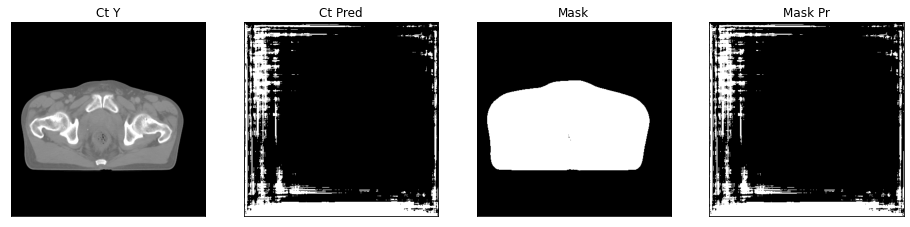

2it [00:01,  1.86it/s]

ssim score = 0.3491133451461792
psnr score = 5.730976104736328
snr score = -4.0337138175964355
mae error = 0.3412766754627228
mask dice score = 0.03888706320648635


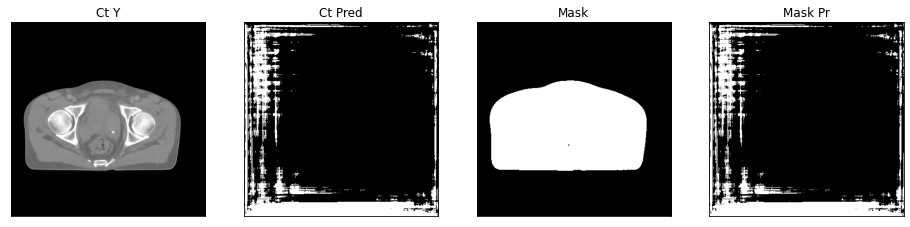

3it [00:01,  2.16it/s]

ssim score = 0.35621631145477295
psnr score = 5.730485916137695
snr score = -4.025428771972656
mae error = 0.33924368023872375
mask dice score = 0.03196047508195006


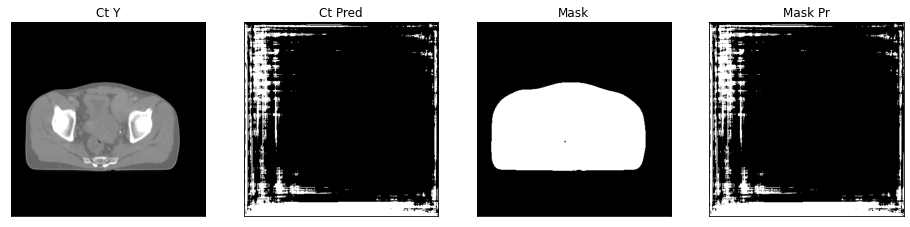

4it [00:01,  2.46it/s]

ssim score = 0.3602621257305145
psnr score = 5.779717445373535
snr score = -4.182873725891113
mae error = 0.33398595452308655
mask dice score = 0.030123322712484996


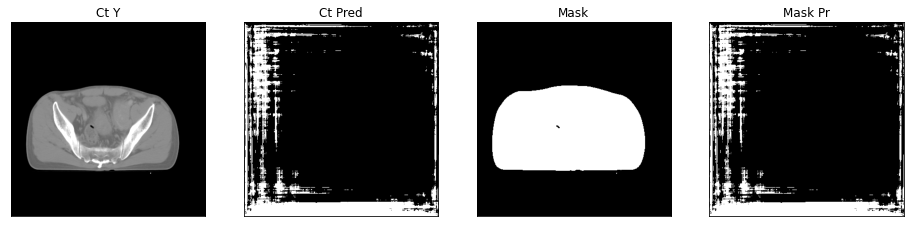

5it [00:01,  2.70it/s]

ssim score = 0.36677730083465576
psnr score = 5.8078436851501465
snr score = -4.384347438812256
mae error = 0.3284340500831604
mask dice score = 0.024277286137132335


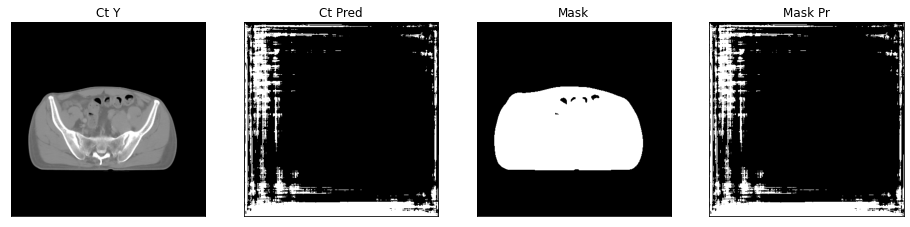

6it [00:02,  2.93it/s]

ssim score = 0.37301671504974365
psnr score = 5.840536117553711
snr score = -4.590076923370361
mae error = 0.3217281997203827
mask dice score = 0.017621145375952


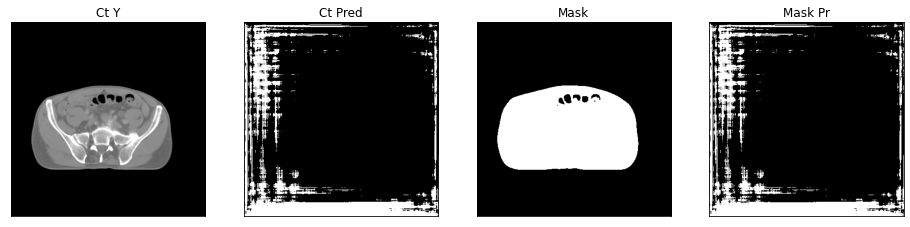

7it [00:02,  3.12it/s]

ssim score = 0.22081683576107025
psnr score = 5.757210731506348
snr score = -2.870631694793701
mae error = 0.3952353298664093
mask dice score = 0.0669935932936536


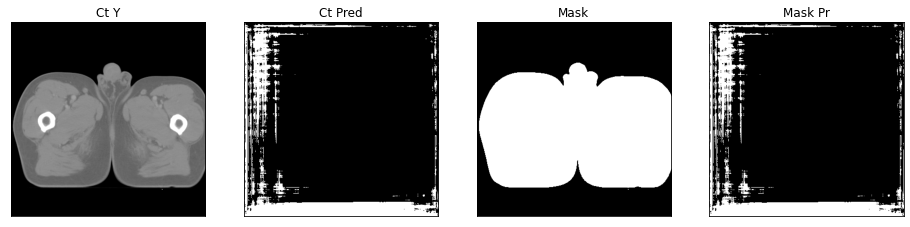

8it [00:02,  3.25it/s]

ssim score = 0.2124258577823639
psnr score = 5.512917518615723
snr score = -2.697519063949585
mae error = 0.41190361976623535
mask dice score = 0.0741369007468877


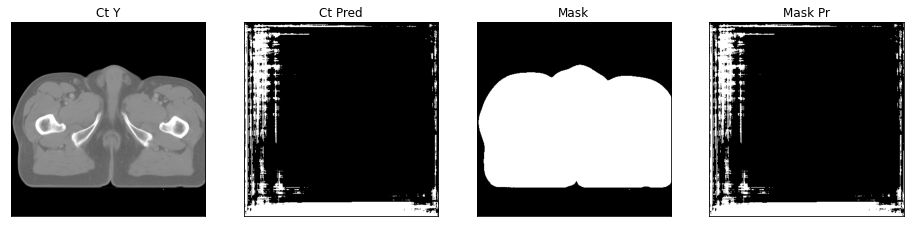

9it [00:03,  3.31it/s]

ssim score = 0.20563802123069763
psnr score = 5.427428245544434
snr score = -2.6362228393554688
mae error = 0.418008953332901
mask dice score = 0.07404300747381229


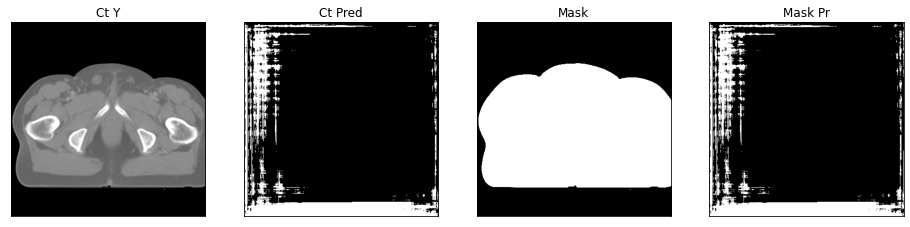

10it [00:03,  3.39it/s]

ssim score = 0.19657504558563232
psnr score = 5.235925197601318
snr score = -2.5406649112701416
mae error = 0.4294790029525757
mask dice score = 0.07233420643143118


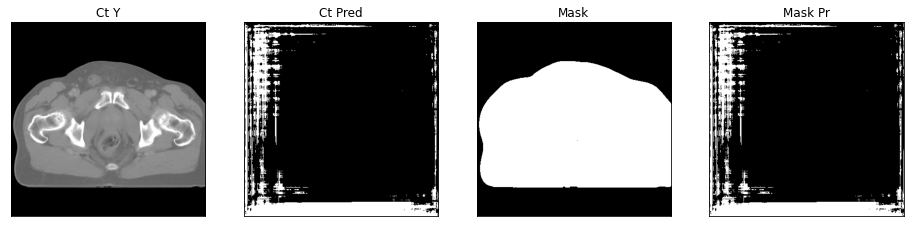

11it [00:03,  3.42it/s]

ssim score = 0.19974282383918762
psnr score = 5.346189498901367
snr score = -2.706916332244873
mae error = 0.422553688287735
mask dice score = 0.06852084271528351


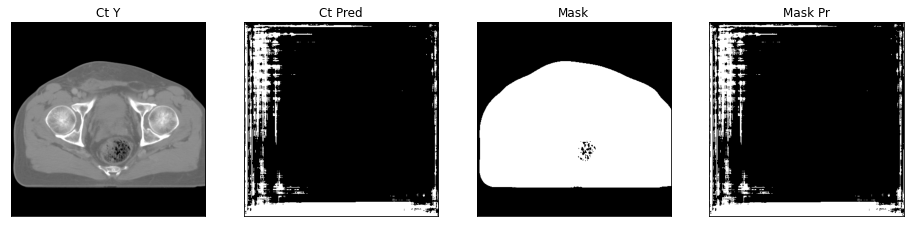

12it [00:03,  3.48it/s]

ssim score = 0.21076607704162598
psnr score = 5.349359512329102
snr score = -2.707019090652466
mae error = 0.4181138277053833
mask dice score = 0.06498180898552017


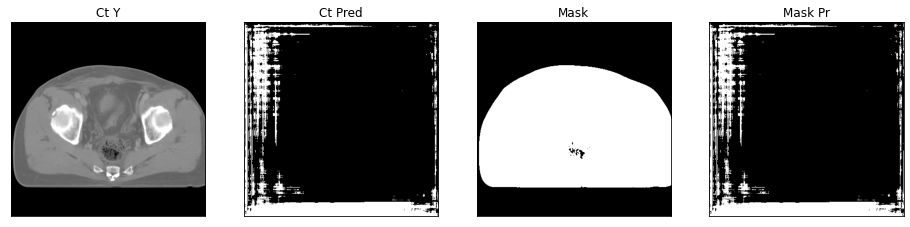

13it [00:04,  3.51it/s]

ssim score = 0.20412319898605347
psnr score = 5.250981330871582
snr score = -2.6926469802856445
mae error = 0.4229387640953064
mask dice score = 0.06128215120902057


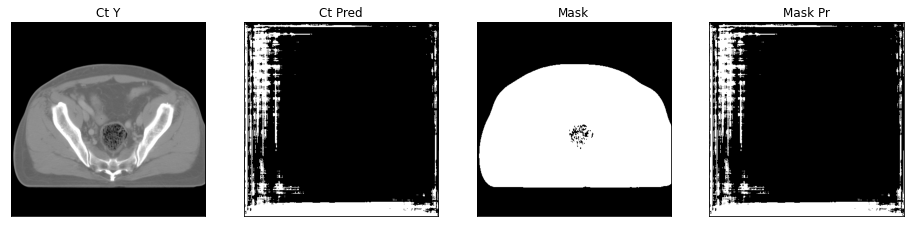

14it [00:04,  3.56it/s]

ssim score = 0.28902778029441833
psnr score = 5.583105564117432
snr score = -4.323706150054932
mae error = 0.36381953954696655
mask dice score = 0.03324940758413155


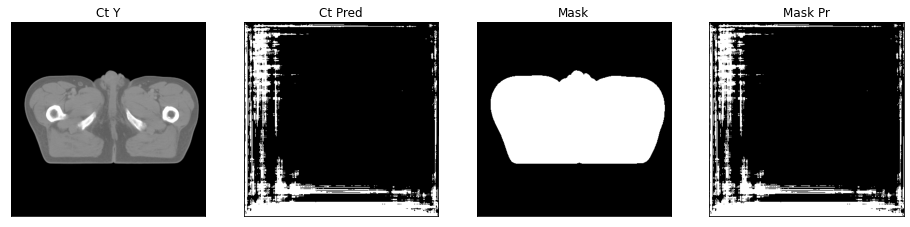

15it [00:04,  3.56it/s]

ssim score = 0.2816069722175598
psnr score = 5.44163179397583
snr score = -4.210456848144531
mae error = 0.3731847107410431
mask dice score = 0.0327597536945594


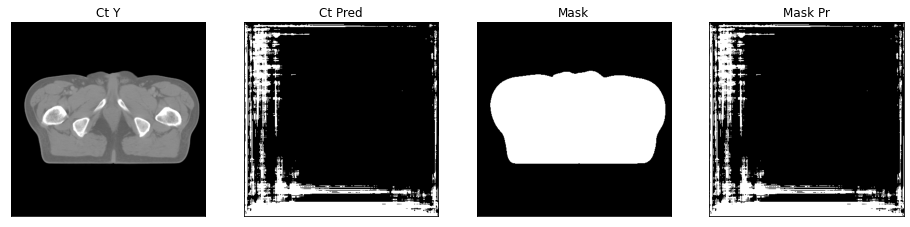

16it [00:04,  3.56it/s]

ssim score = 0.2759764492511749
psnr score = 5.354002952575684
snr score = -4.1339111328125
mae error = 0.37966445088386536
mask dice score = 0.029480890454230517


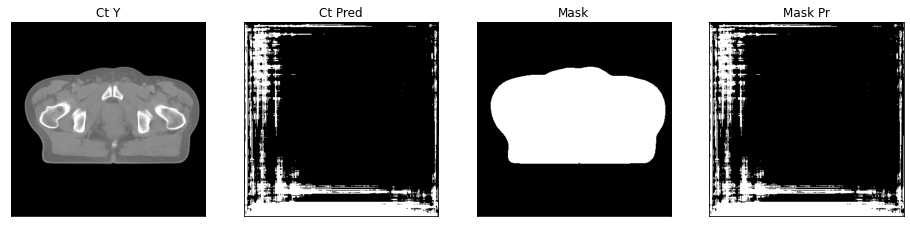

17it [00:05,  3.55it/s]

ssim score = 0.26368263363838196
psnr score = 5.253729820251465
snr score = -4.064818382263184
mae error = 0.38613465428352356
mask dice score = 0.025485029941286843


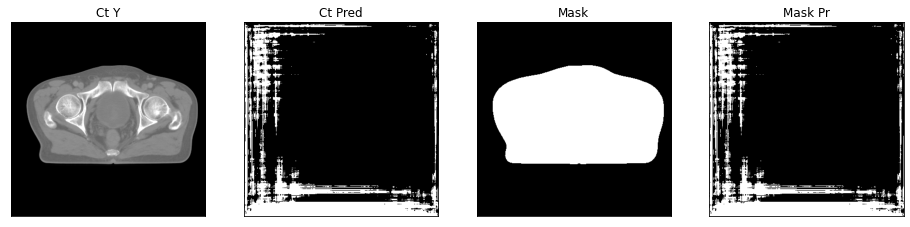

18it [00:05,  3.56it/s]

ssim score = 0.26611757278442383
psnr score = 5.453916549682617
snr score = -4.138190269470215
mae error = 0.3746339976787567
mask dice score = 0.022692506896856663


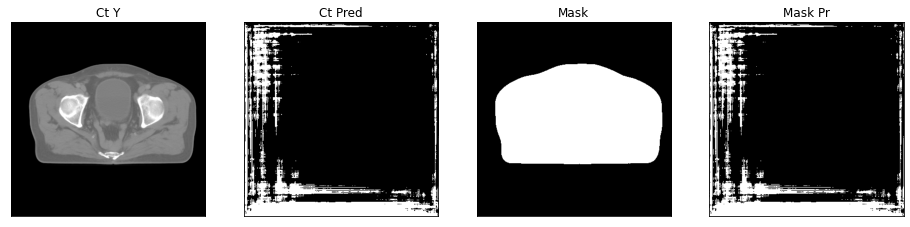

19it [00:05,  3.57it/s]

ssim score = 0.26616987586021423
psnr score = 5.482154846191406
snr score = -4.079854965209961
mae error = 0.37431615591049194
mask dice score = 0.022121717433422363


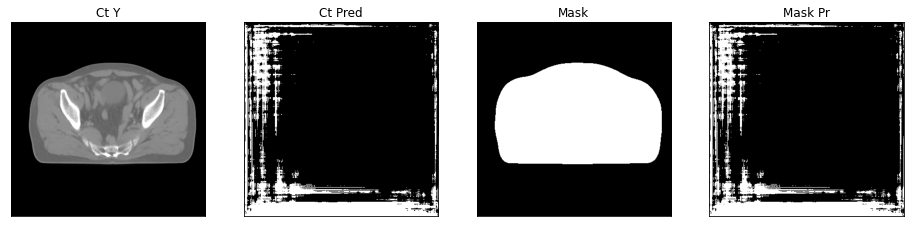

20it [00:06,  3.59it/s]

ssim score = 0.26186859607696533
psnr score = 5.365693092346191
snr score = -4.060072898864746
mae error = 0.38137876987457275
mask dice score = 0.021395725621236813


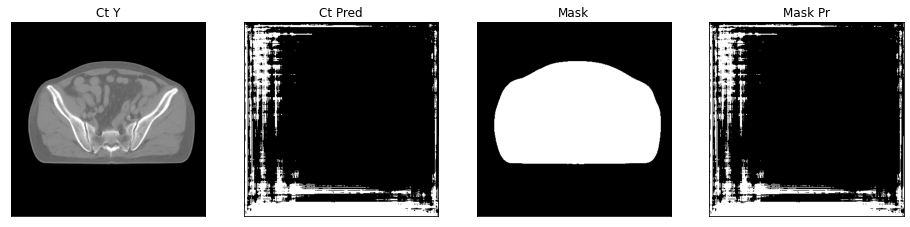

21it [00:06,  3.57it/s]

ssim score = 0.29062017798423767
psnr score = 5.844917297363281
snr score = -3.3958520889282227
mae error = 0.3634794056415558
mask dice score = 0.07728262114895489


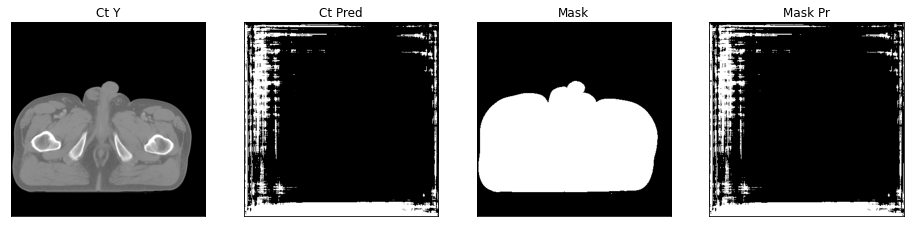

22it [00:06,  3.58it/s]

ssim score = 0.27892714738845825
psnr score = 5.7954864501953125
snr score = -3.440807819366455
mae error = 0.3653520941734314
mask dice score = 0.07988457046116862


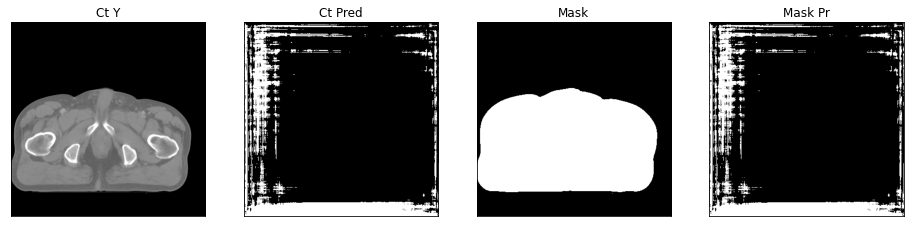

23it [00:06,  3.57it/s]

ssim score = 0.2756138741970062
psnr score = 5.664992332458496
snr score = -3.3537375926971436
mae error = 0.3723229467868805
mask dice score = 0.07804799963516842


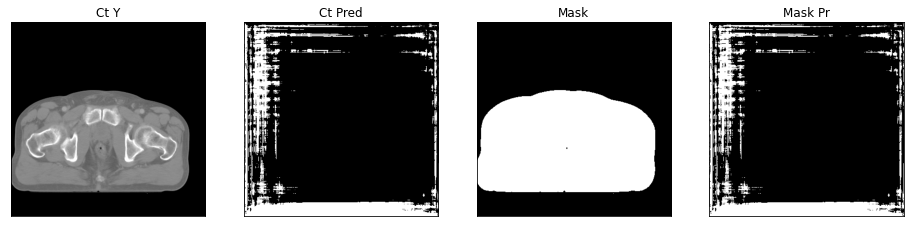

24it [00:07,  3.58it/s]

ssim score = 0.2757219076156616
psnr score = 5.741204261779785
snr score = -3.4549214839935303
mae error = 0.36753350496292114
mask dice score = 0.07838092394032026


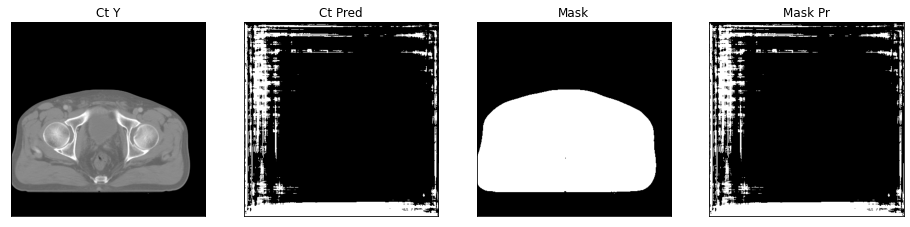

25it [00:07,  2.91it/s]

ssim score = 0.27760496735572815
psnr score = 5.770859241485596
snr score = -3.5500094890594482
mae error = 0.3625354766845703
mask dice score = 0.07624092786740538


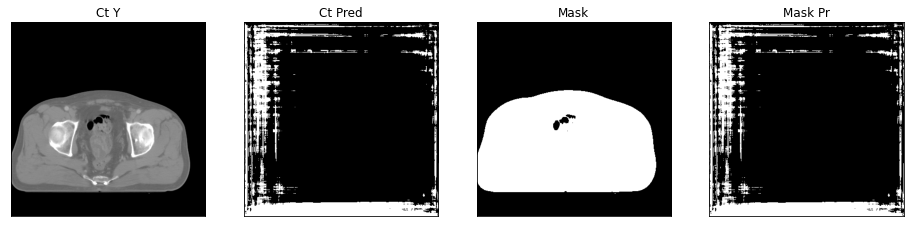

26it [00:07,  3.08it/s]

ssim score = 0.28434157371520996
psnr score = 5.80350399017334
snr score = -3.7161829471588135
mae error = 0.35663241147994995
mask dice score = 0.0751315521365084


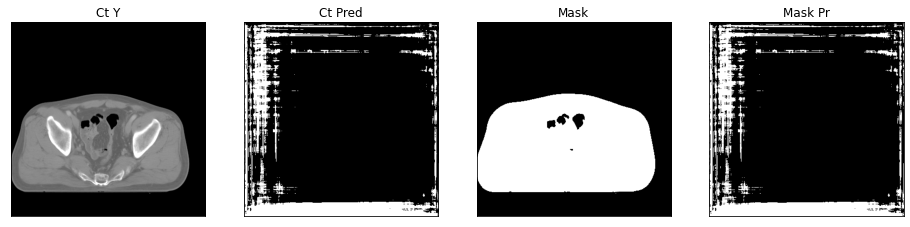

27it [00:08,  3.21it/s]

ssim score = 0.2939610481262207
psnr score = 5.775143623352051
snr score = -3.755753993988037
mae error = 0.3544524312019348
mask dice score = 0.07168397335536872


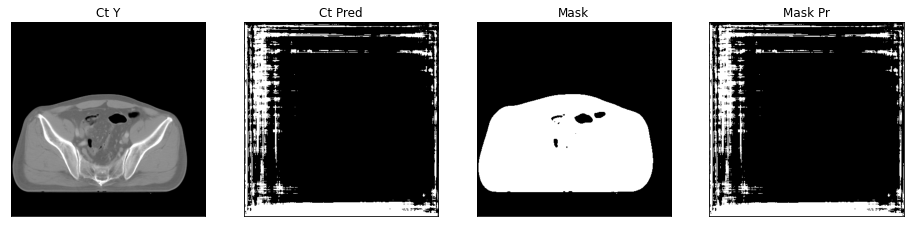

28it [00:08,  3.31it/s]

ssim score = 0.20433799922466278
psnr score = 5.594882488250732
snr score = -2.44327449798584
mae error = 0.4112945795059204
mask dice score = 0.0919496700537838


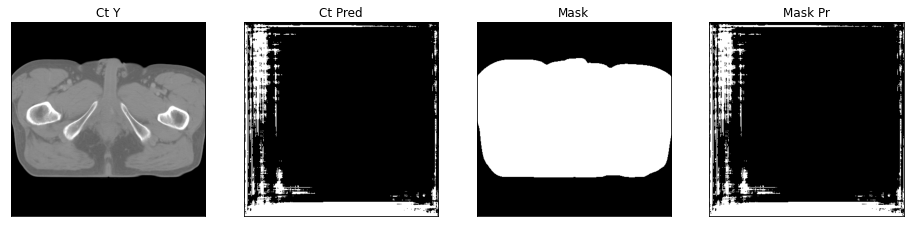

29it [00:08,  3.38it/s]

ssim score = 0.19434984028339386
psnr score = 5.504825592041016
snr score = -2.409292697906494
mae error = 0.41830047965049744
mask dice score = 0.0915514018700079


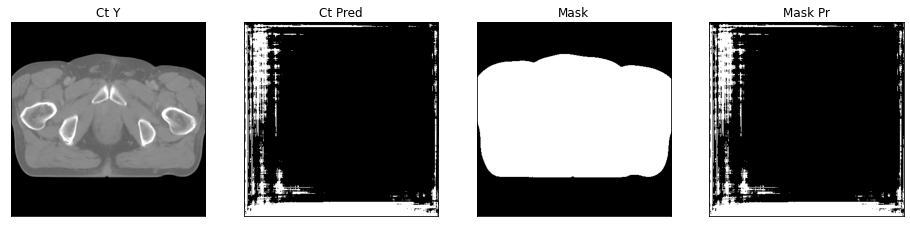

30it [00:09,  3.43it/s]

ssim score = 0.1891760528087616
psnr score = 5.374144554138184
snr score = -2.3675661087036133
mae error = 0.42701438069343567
mask dice score = 0.09275421525747164


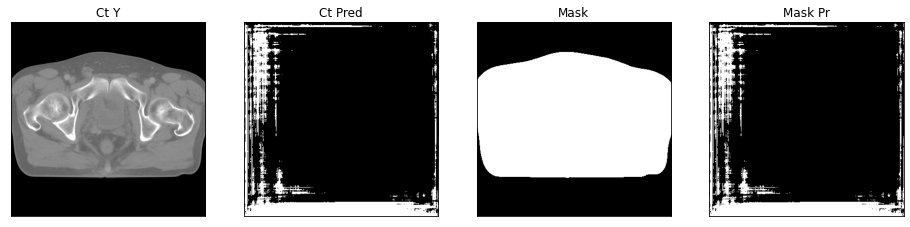

31it [00:09,  3.58it/s]

ssim score = 0.19473087787628174
psnr score = 5.606377601623535
snr score = -2.553441286087036
mae error = 0.41118553280830383
mask dice score = 0.08873234159039164


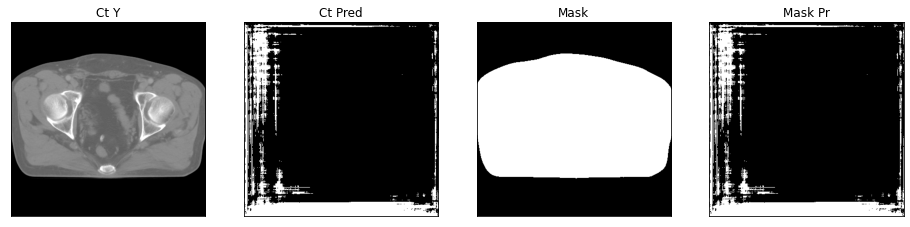

32it [00:09,  3.58it/s]

ssim score = 0.20173156261444092
psnr score = 5.671859264373779
snr score = -2.6344656944274902
mae error = 0.4048267900943756
mask dice score = 0.08189391623444485


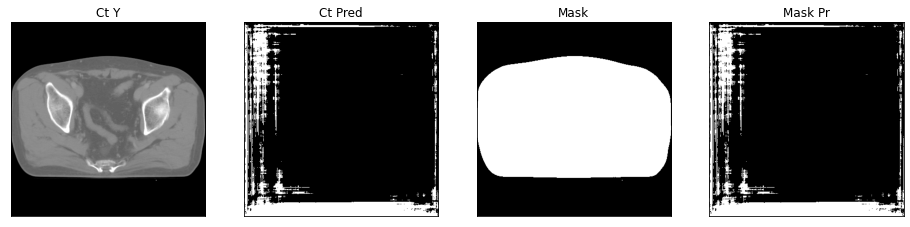

33it [00:09,  3.57it/s]

ssim score = 0.20480714738368988
psnr score = 5.526834487915039
snr score = -2.6111083030700684
mae error = 0.4103187918663025
mask dice score = 0.07678195284454636


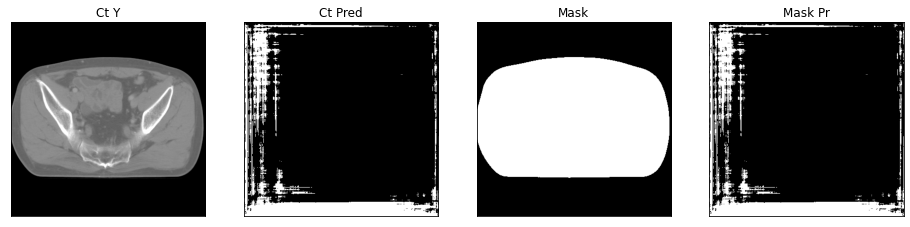

34it [00:10,  3.58it/s]

ssim score = 0.2265404462814331
psnr score = 5.100649833679199
snr score = -3.42195987701416
mae error = 0.41849642992019653
mask dice score = 0.060446944836109344


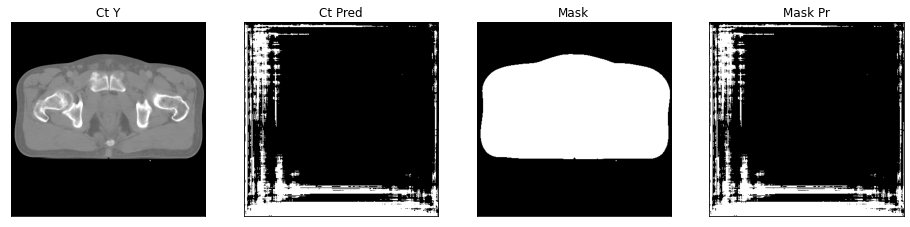

35it [00:10,  3.57it/s]

ssim score = 0.22743701934814453
psnr score = 5.178567886352539
snr score = -3.510286569595337
mae error = 0.4135707914829254
mask dice score = 0.0585883534987037


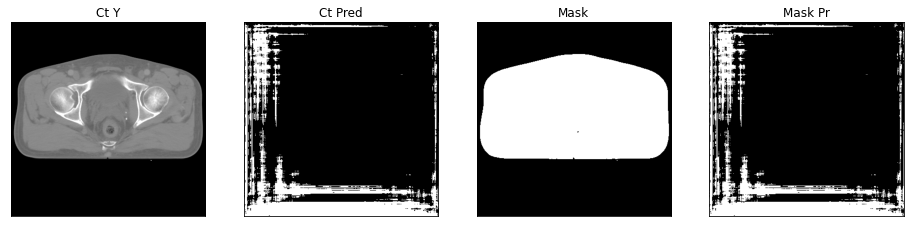

36it [00:10,  3.58it/s]

ssim score = 0.23225025832653046
psnr score = 5.185375690460205
snr score = -3.474766254425049
mae error = 0.41040992736816406
mask dice score = 0.05571030640768918


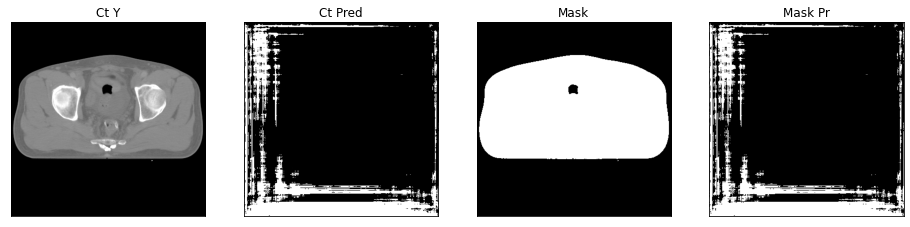

37it [00:11,  3.62it/s]

ssim score = 0.23800183832645416
psnr score = 5.254112243652344
snr score = -3.5437235832214355
mae error = 0.4040064811706543
mask dice score = 0.05451422274661094


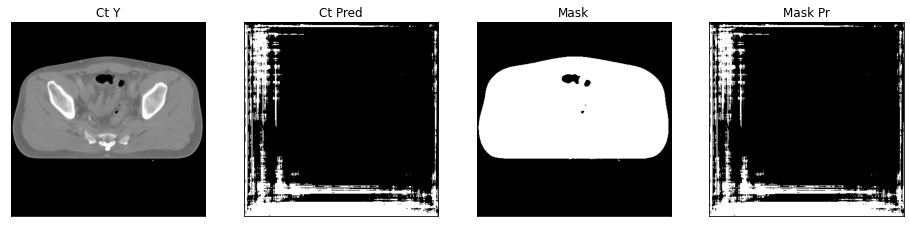

38it [00:11,  3.62it/s]

ssim score = 0.23824991285800934
psnr score = 5.172645568847656
snr score = -3.5919973850250244
mae error = 0.4068930447101593
mask dice score = 0.05374230197020306


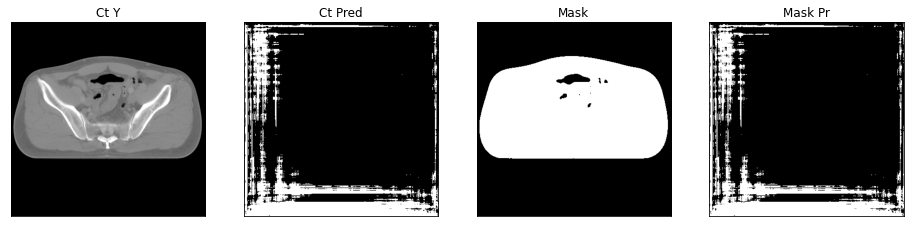

39it [00:11,  3.60it/s]

ssim score = 0.23056457936763763
psnr score = 5.14078426361084
snr score = -3.6565229892730713
mae error = 0.4089168310165405
mask dice score = 0.050777908903943375


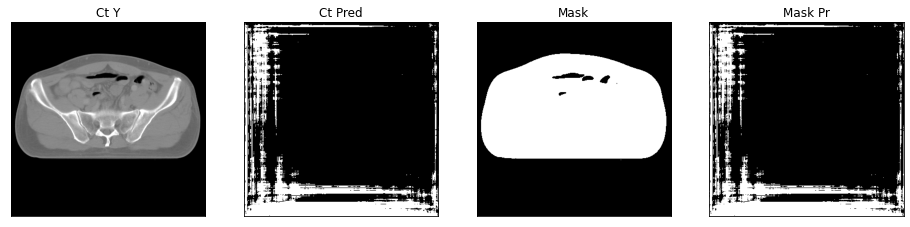

40it [00:11,  3.62it/s]

ssim score = 0.21938428282737732
psnr score = 5.16547966003418
snr score = -3.7674591541290283
mae error = 0.408444881439209
mask dice score = 0.04625456106562969


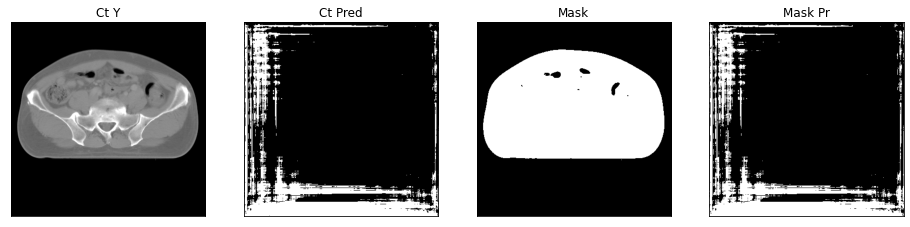

41it [00:12,  3.58it/s]

ssim score = 0.2622748017311096
psnr score = 5.961549282073975
snr score = -3.657538890838623
mae error = 0.36355558037757874
mask dice score = 0.06510641554086083


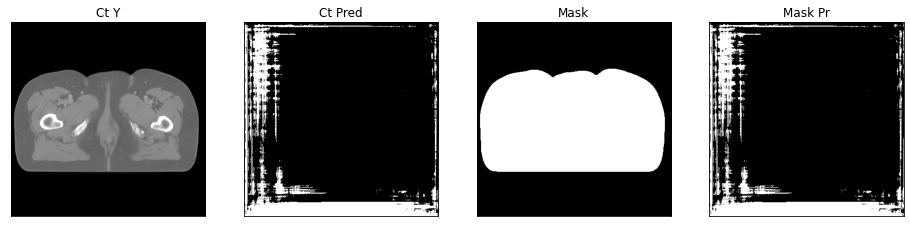

42it [00:12,  3.60it/s]

ssim score = 0.24704211950302124
psnr score = 5.788819313049316
snr score = -3.534432888031006
mae error = 0.375080943107605
mask dice score = 0.06612190623357556


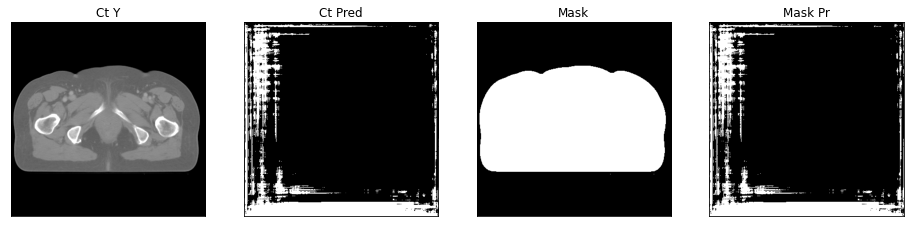

43it [00:12,  3.59it/s]

ssim score = 0.24322152137756348
psnr score = 5.708514213562012
snr score = -3.4693491458892822
mae error = 0.38059303164482117
mask dice score = 0.0660810753338444


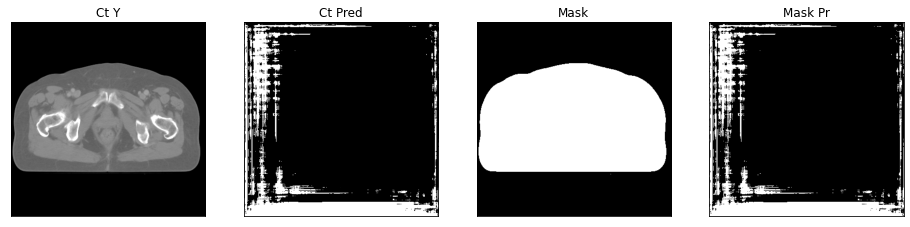

44it [00:12,  3.63it/s]

ssim score = 0.2425113022327423
psnr score = 5.7302021980285645
snr score = -3.484658718109131
mae error = 0.38068026304244995
mask dice score = 0.06394448099592102


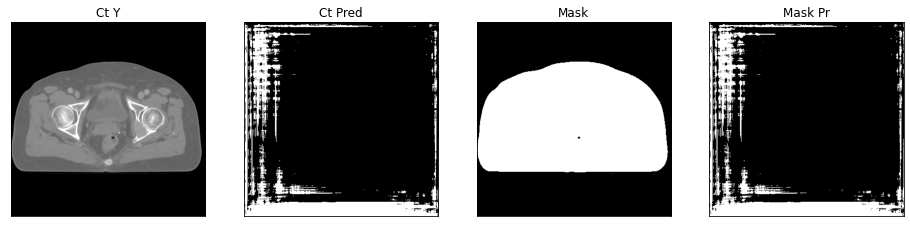

45it [00:13,  3.62it/s]

ssim score = 0.23444576561450958
psnr score = 5.739019393920898
snr score = -3.425252676010132
mae error = 0.3810483515262604
mask dice score = 0.06354395892375192


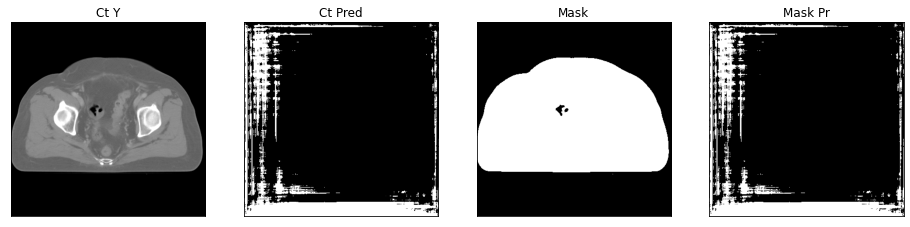

46it [00:13,  3.63it/s]

ssim score = 0.2160710245370865
psnr score = 5.769510746002197
snr score = -3.382718801498413
mae error = 0.38533151149749756
mask dice score = 0.06278456257671065


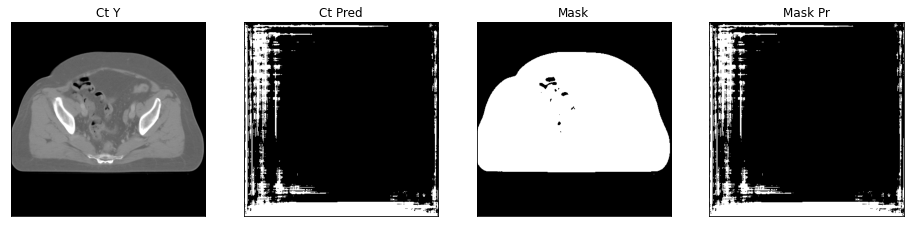

47it [00:13,  3.61it/s]

ssim score = 0.19983918964862823
psnr score = 5.685683250427246
snr score = -3.2784523963928223
mae error = 0.3925774395465851
mask dice score = 0.06517397036005955


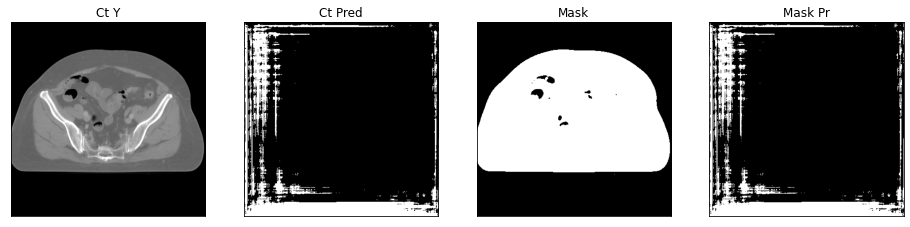

48it [00:14,  3.33it/s]


In [33]:
test_epoch(model, testloader, device, True, os.path.join("eval-autoencoder", run_name))

In [34]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, score_mask_test
eval_epoch(model, testloader, device)

48it [00:05,  9.14it/s]


(0.2540290579199791,
 5.551412105560303,
 -3.4409776826699576,
 0.3849556564042966,
 0.05846204800273266)